In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data_dir = 'Data/PriceData'

def load_data():
    data_frames = {}
    files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
    for file in tqdm(files, desc="Loading Parquet files"):
        ticker = file.split('.')[0]
        df = pd.read_parquet(os.path.join(data_dir, file))
        df['Return'] = df['Close'].pct_change().fillna(method='ffill')
        data_frames[ticker] = df
    return data_frames

def calculate_weighted_returns(data_frames, weights):
    daily_returns = pd.DataFrame({ticker: df['Return'] for ticker, df in data_frames.items()})
    weekly_returns = daily_returns.resample('W').apply(lambda x: (1 + x).prod() - 1)
    monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    
    weighted_returns = (weights['daily'] * daily_returns +
                        weights['weekly'] * weekly_returns.reindex(daily_returns.index, method='ffill') +
                        weights['monthly'] * monthly_returns.reindex(daily_returns.index, method='ffill'))
    
    return weighted_returns

def cluster_stocks(correlation_matrix):
    scaler = StandardScaler()
    scaled_correlation = scaler.fit_transform(correlation_matrix)
    
    kmeans = KMeans(n_clusters=6, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(scaled_correlation)
    
    return pd.Series(clusters, index=correlation_matrix.index, name='Cluster')

def calculate_cluster_metrics(correlation_matrix, clusters):
    cluster_means = {}
    for cluster in clusters.unique():
        cluster_stocks = clusters[clusters == cluster].index
        cluster_means[cluster] = correlation_matrix.loc[cluster_stocks, cluster_stocks].mean().mean()
    
    return pd.Series(cluster_means)

def calculate_stock_to_cluster_correlations(correlation_matrix, clusters, cluster_means):
    correlations = pd.DataFrame(index=correlation_matrix.index, 
                                columns=[f'correlation_{i}' for i in range(len(cluster_means))])
    
    for cluster in cluster_means.index:
        cluster_stocks = clusters[clusters == cluster].index
        correlations[f'correlation_{cluster}'] = correlation_matrix[cluster_stocks].mean(axis=1)
    
    return correlations

if __name__ == "__main__":
    # Load data
    data_frames = load_data()
    
    # Calculate weighted returns
    weights = {'daily': 0.65, 'weekly': 0.25, 'monthly': 0.10}
    weighted_returns = calculate_weighted_returns(data_frames, weights)
    
    # Calculate correlation matrix
    correlation_matrix = weighted_returns.corr()
    
    # Cluster stocks
    clusters = cluster_stocks(correlation_matrix)
    
    # Calculate cluster metrics
    cluster_means = calculate_cluster_metrics(correlation_matrix, clusters)
    
    # Calculate stock-to-cluster correlations
    stock_cluster_correlations = calculate_stock_to_cluster_correlations(correlation_matrix, clusters, cluster_means)
    
    # Prepare final DataFrame
    result = pd.DataFrame({
        'Ticker': correlation_matrix.index,
        'Cluster': clusters
    })
    result = result.join(stock_cluster_correlations)
    result['mean_intragroup_correlation'] = result['Cluster'].map(cluster_means)
    result['diff_to_mean_group_corr'] = result.apply(
        lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)
    
    # Reorder columns
    reordered_columns = (['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + 
                         [col for col in result.columns if col.startswith('correlation_')])
    result = result[reordered_columns].round(5)
    
    # Save results
    result.to_parquet('Correlations.parquet', index=False)
    print("Correlations saved to 'Correlations.parquet'.")

Loading Parquet files: 100%|██████████| 6629/6629 [00:10<00:00, 649.61it/s]
c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from numba import njit

data_dir = 'Data/PriceData'

# Load Parquet files into data_frames dictionary
data_frames = {}
files = [file for file in os.listdir(data_dir) if file.endswith('.parquet')]
for file in tqdm(files, desc="Loading Parquet files"):
    ticker = file.split('.')[0]
    data_frames[ticker] = pd.read_parquet(os.path.join(data_dir, file))

@njit
def calculate_dynamic_weights(volatility, mean_volatility, std_volatility):
    if std_volatility == 0:
        return np.array([0.25, 0.25, 0.25, 0.25])
    
    z_score = (volatility - mean_volatility) / std_volatility
    weights = np.array([0.25 - 0.1*z_score, 0.25 - 0.05*z_score, 0.25 + 0.05*z_score, 0.25 + 0.1*z_score])
    weights = np.maximum(np.minimum(weights, 1), 0)  # This replaces np.clip
    return weights / np.sum(weights)

@njit
def calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility):
    weighted_returns = np.zeros(len(returns))
    for i in range(21, len(returns)):
        weights = calculate_dynamic_weights(volatility[i], mean_volatility[i], std_volatility[i])
        weighted_returns[i] = np.sum(returns[i] * weights)
    return weighted_returns

def process_stock_data(df):
    df['Daily_Return'] = df['Close'].pct_change().fillna(method='bfill').round(3)
    df['Weekly_Return'] = df['Close'].pct_change(5).fillna(method='bfill').round(3)
    df['Monthly_Return'] = df['Close'].pct_change(21).fillna(method='bfill').round(3)
    df['Yearly_Return'] = df['Close'].pct_change(252).fillna(method='bfill').round(3)

    df['Volatility'] = df['Daily_Return'].rolling(window=21).std().fillna(method='bfill')
    df['Mean_Volatility'] = df['Volatility'].rolling(window=21).mean().fillna(method='bfill')
    df['Volatility_Std'] = df['Volatility'].rolling(window=21).std().fillna(method='bfill')

    returns = np.column_stack((df['Daily_Return'], df['Weekly_Return'], df['Monthly_Return'], df['Yearly_Return']))
    volatility = df['Volatility'].values
    mean_volatility = df['Mean_Volatility'].values
    std_volatility = df['Volatility_Std'].values

    df['Weighted_Return'] = calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility)
    df['Weighted_Return'] = df['Weighted_Return'].round(3)

    return df

# Process all stocks
for ticker, df in tqdm(data_frames.items(), desc="Processing stocks"):
    data_frames[ticker] = process_stock_data(df)

returns_df = pd.DataFrame({ticker: df['Weighted_Return'] for ticker, df in data_frames.items()}).fillna(method='bfill')

correlation_matrix = returns_df.corr().fillna(method='bfill').fillna(method='ffill')

scaler = StandardScaler()
scaled_correlation = scaler.fit_transform(correlation_matrix)

# Perform clustering
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
clusters = kmeans.fit_predict(scaled_correlation)

correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df['Cluster'] = clusters

# Elbow Method
inertia = []
for k in tqdm(range(2, 20), desc="Elbow Method"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_correlation)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in tqdm(range(2, 20), desc="Silhouette Score"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(scaled_correlation)
    silhouette_scores.append(silhouette_score(scaled_correlation, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()

clustered_assets = correlation_matrix_df[['Cluster']].reset_index()
clustered_assets.columns = ['Ticker', 'Cluster']

def calculate_group_correlations_vectorized(correlation_matrix, clustered_assets):
    corr_array = correlation_matrix.values
    unique_clusters = clustered_assets['Cluster'].unique()
    cluster_indices = {cluster: clustered_assets.index[clustered_assets['Cluster'] == cluster].tolist() 
                       for cluster in unique_clusters}
    
    result = pd.DataFrame(index=correlation_matrix.index, 
                          columns=[f'correlation_{cluster}' for cluster in unique_clusters])
    
    for cluster in tqdm(unique_clusters, desc="Calculating Group Correlations"):
        indices = cluster_indices[cluster]
        cluster_correlations = corr_array[:, indices].mean(axis=1)
        result[f'correlation_{cluster}'] = cluster_correlations
    
    return result

group_correlations = calculate_group_correlations_vectorized(correlation_matrix, clustered_assets)

clustered_assets = clustered_assets.merge(group_correlations, left_on='Ticker', right_index=True)

mean_intra_group_corr = clustered_assets.groupby('Cluster')[group_correlations.columns].mean().mean(axis=1)
clustered_assets['mean_intragroup_correlation'] = clustered_assets['Cluster'].map(mean_intra_group_corr)
clustered_assets['diff_to_mean_group_corr'] = clustered_assets.apply(
    lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)

reordered_columns = ['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + list(group_correlations.columns)
clustered_assets = clustered_assets[reordered_columns].round(5)

clustered_assets.to_parquet('Correlations.parquet', index=False)

pd.set_option('display.max_rows', None)
print(clustered_assets[['Ticker', 'Cluster']])

print("Correlations saved to 'Correlations.parquet'.")

Processing stocks: 100%|██████████| 6629/6629 [00:16<00:00, 397.11it/s]
c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Masam\miniconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Index(['GPR', 'GPRT', 'GPRA', 'GPRH', 'GPRHT', 'GPRHA', 'SHARE_GPR', 'N10',
       'SHARE_GPRH', 'N3H',
       ...
       'GPRHC_THA', 'GPRHC_TUN', 'GPRHC_TUR', 'GPRHC_TWN', 'GPRHC_UKR',
       'GPRHC_USA', 'GPRHC_VEN', 'GPRHC_VNM', 'GPRHC_ZAF', 'Year'],
      dtype='object', length=113)


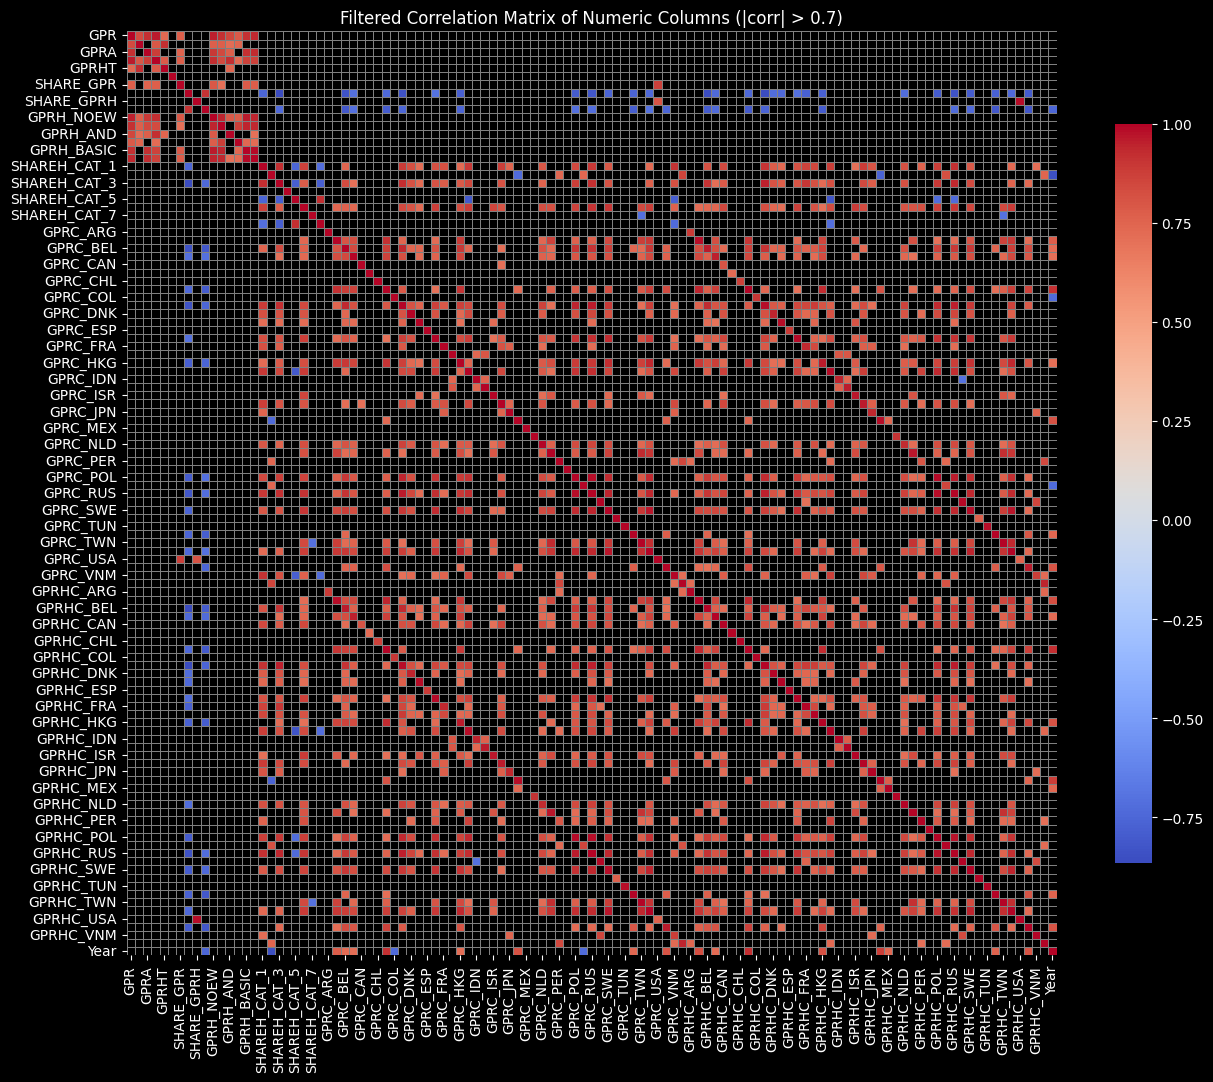

In [19]:
# Rebuilding everything step by step to make sure the filtered correlation matrix and plotting works
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
##set the printer to not cap out after just a few row but print the entyire thinbg for me 
pd.set_option('display.max_rows', None)
# Load the processed and annotated Parquet file
df = pd.read_parquet('data_gpr_export_annotated.parquet')

# Remove data before 1990
df = df[df['Year'] >= 1990]

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)




# Resample the data to a daily timeframe, interpolating using spline method for numeric data
df_daily = df.resample('D').interpolate(method='spline', order=3)

# Fill forward and backward for 'Party' column (R or D flags)
df_daily['Party'] = df_daily['Party'].fillna(method='ffill').fillna(method='bfill')

# Regenerate the correlation matrix for numeric columns
numeric_columns = df_daily.select_dtypes(include=[np.number]).columns
correlation_matrix = df_daily[numeric_columns].corr()

# Filter the correlation matrix to display only highly correlated values (above 0.7 or below -0.7)
threshold = 0.7
filtered_corr_matrix = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Apply dark background and adjust the plot
plt.style.use('dark_background')

# Masking the values where the correlation is NaN (to not include them in the plot)
mask = filtered_corr_matrix.isnull()

##print all columns that have a cor of at least 0.7
#print the column names of the columns that have a correlation of at least 0.7
print(filtered_corr_matrix.columns)



# Increase the figure size for better readability
plt.figure(figsize=(15, 12))

# Plotting the heatmap with a dark background, white text, and removing the masked (NaN) values
sns.heatmap(filtered_corr_matrix, annot=False, cmap="coolwarm", fmt='.2f', linewidths=0.5, linecolor='gray', 
            mask=mask, cbar_kws={"shrink": .8})

plt.title("Filtered Correlation Matrix of Numeric Columns (|corr| > 0.7)", color='white')
plt.show()


In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load geopolitical risk data
gpr_data = pd.read_parquet('data_gpr_export_annotated.parquet')

# Remove data before 1990
gpr_data = gpr_data[gpr_data['Year'] >= 1990]

# Set 'Date' as the index
gpr_data.set_index('Date', inplace=True)

# Load all stock price data and process it
data_dir = 'Data/PriceData'
data_frames = {}
files = [file for file in os.listdir(data_dir) if file.endswith('.parquet')]

for file in tqdm(files, desc="Loading Parquet files"):
    ticker = file.split('.')[0]
    df = pd.read_parquet(os.path.join(data_dir, file))
    
    # Ensure 'Date' is either in the index or columns
    if 'Date' not in df.columns and df.index.name == 'Date':
        df = df.reset_index()
    
    # Ensure 'Date' is a datetime object and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Merge with geopolitical data (on date index)
    df = df.merge(gpr_data, how='inner', left_index=True, right_index=True)
    
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change().fillna(0)
    
    # Store in dictionary
    data_frames[ticker] = df

# Create a dataframe of correlations between asset returns and GPR indices
correlations = pd.DataFrame(index=data_frames.keys())

gpr_columns = ['GPR', 'GPRT', 'GPRA', 'GPRH']  # Select important GPR columns

# For each asset, calculate the correlation with GPR indices
for ticker, df in data_frames.items():
    for gpr_col in gpr_columns:
        correlations.loc[ticker, f'correlation_{gpr_col}'] = df['Daily_Return'].corr(df[gpr_col])

# Normalize correlations for clustering
scaler = StandardScaler()
scaled_correlations = scaler.fit_transform(correlations)

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
clusters = kmeans.fit_predict(scaled_correlations)

# Add clusters to the correlation dataframe
correlations['Cluster'] = clusters

# Plot the Elbow Method to find the optimal number of clusters
inertia = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_correlations)
    inertia.append(kmeans.inertia_)



# Plot silhouette scores
silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(scaled_correlations)
    silhouette_scores.append(silhouette_score(scaled_correlations, labels))



# Display clustered assets
correlations['Cluster'] = clusters
print(correlations[['Cluster']])


FileNotFoundError: [Errno 2] No such file or directory: 'data_gpr_export_annotated.parquet'

In [25]:
import numpy as np

# Calculate intra-cluster and inter-cluster correlations
def calculate_cluster_relationships(correlation_matrix, clustered_assets):
    unique_clusters = clustered_assets['Cluster'].unique()
    cluster_indices = {cluster: clustered_assets.index[clustered_assets['Cluster'] == cluster].tolist() 
                       for cluster in unique_clusters}
    
    # Create a dataframe to hold the inter-cluster and intra-cluster correlations
    cluster_relationships = pd.DataFrame(index=unique_clusters, columns=unique_clusters)
    
    # Loop over all cluster combinations to compute the average correlations
    for cluster_i in unique_clusters:
        for cluster_j in unique_clusters:
            # Get the indices for both clusters
            indices_i = cluster_indices[cluster_i]
            indices_j = cluster_indices[cluster_j]
            
            # Extract the correlations between the two clusters
            cluster_corr = correlation_matrix.values[np.ix_(indices_i, indices_j)]
            
            # Compute the mean correlation between the clusters
            cluster_relationships.loc[cluster_i, cluster_j] = np.mean(cluster_corr)
    
    return cluster_relationships

# Get the cluster relationships
cluster_relationships = calculate_cluster_relationships(correlation_matrix, correlations)

# Print out some sample text to describe the clusters
for cluster in cluster_relationships.index:
    intra_cluster_corr = cluster_relationships.loc[cluster, cluster]
    print(f"Cluster {cluster} has an average intra-cluster correlation of {intra_cluster_corr:.2f}")
    
    for other_cluster in cluster_relationships.columns:
        if other_cluster != cluster:
            inter_cluster_corr = cluster_relationships.loc[cluster, other_cluster]
            print(f"  The average correlation between Cluster {cluster} and Cluster {other_cluster} is {inter_cluster_corr:.2f}")

# Visualize the cluster relationships as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_relationships.astype(float), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Inter-cluster and Intra-cluster Correlations")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()


IndexError: arrays used as indices must be of integer (or boolean) type